## Data Collection for BRK Options Prediction

This code collects historical stock price data for Berkshire Hathaway (BRK-B), S&P 500 (^GSPC), and Dow Jones (^DJI) from Yahoo Finance using the `yfinance` library. It retrieves daily data (Open, High, Low, Close, Adj Close, Volume) from 2010 to present, saving clean CSVs for analysis. The data supports linear regression to predict BRK prices and identify undervalued call options. Financial metrics (P/E, price/book, cash ratio) are being automated via MacroTrends scraping, with manual collection as a fallback. The code includes error handling and produces structured datasets for preprocessing.

In [1]:
import yfinance as yf
import pandas as pd
from datetime import datetime

# Set pandas display options for better readability
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# --- Part 1: Download Historical Data with yfinance ---

# Define tickers
tickers = {
    'BRK-B': 'Berkshire Hathaway',
    '^GSPC': 'S&P 500',
    '^DJI': 'Dow Jones'
}

# Define date range
start_date = '2010-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')

# List to store dataframes
dataframes = []

# Download data for each ticker
for ticker, name in tickers.items():
    try:
        print(f"Downloading data for {name} ({ticker})...")
        # Fetch data using yfinance
        df = yf.download(ticker, start=start_date, end=end_date, auto_adjust=False, progress=False)
        if df.empty:
            print(f"No data retrieved for {name} ({ticker}).")
            continue
        # Select relevant columns, including Adj Close
        df = df[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]
        # Reset index to make Date a column and clear index name
        df.reset_index(inplace=True)
        df.index.name = None  # Clear any residual index name
        # Add ticker column
        df['Ticker'] = ticker
        # Rename columns to ensure clarity
        df.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Ticker']
        # Convert Date to datetime
        df['Date'] = pd.to_datetime(df['Date'])
        # Store dataframe
        dataframes.append(df)
        # Save individual CSV
        csv_filename = f"{ticker.replace('^', '')}_data.csv"
        df.to_csv(csv_filename, index=False)  # Save without index
        print(f"Data for {name} saved to {csv_filename}")
        # Display first few rows
        print(f"\n{name} Data (first 5 rows):")
        print(df.head())
        print("\n")
    except Exception as e:
        print(f"Error downloading data for {name} ({ticker}): {e}")

# Combine all data into a single CSV
if dataframes:
    combined_df = pd.concat(dataframes, ignore_index=True)
    # Ensure correct column order
    combined_df = combined_df[['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Ticker']]
    # Save combined CSV
    combined_df.to_csv('combined_data.csv', index=False)
    print("Combined data saved to combined_data.csv")
    print("\nCombined Data (first 5 rows):")
    print(combined_df.head())
else:
    print("No data collected.")


Data for Berkshire Hathaway saved to BRK-B_data.csv

Berkshire Hathaway Data (first 5 rows):
        Date       Open       High        Low      Close  Adj Close   Volume Ticker
0 2010-01-04  66.000000  66.500000  65.919998  66.220001  66.220001  1575000  BRK-B
1 2010-01-05  66.389999  66.589996  66.150002  66.540001  66.540001  1310000  BRK-B
2 2010-01-06  66.500000  66.500000  66.199997  66.199997  66.199997  1760000  BRK-B
3 2010-01-07  66.199997  66.510002  66.139999  66.459999  66.459999  1505000  BRK-B
4 2010-01-08  66.480003  66.480003  66.300003  66.440002  66.440002  1500000  BRK-B


Data for S&P 500 saved to GSPC_data.csv

S&P 500 Data (first 5 rows):
        Date         Open         High          Low        Close    Adj Close      Volume Ticker
0 2010-01-04  1116.560059  1133.869995  1116.560059  1132.989990  1132.989990  3991400000  ^GSPC
1 2010-01-05  1132.660034  1136.630005  1129.660034  1136.520020  1136.520020  2491020000  ^GSPC
2 2010-01-06  1135.709961  1139.189941  

## Check BRK Financial Data

In [2]:

financial_df = pd.read_csv('brk_financials.csv')
financial_df['Date'] = pd.to_datetime(financial_df['Date'])

# Restrict date range
financial_df = financial_df[(financial_df['Date'] >= '2010-01-01') & (financial_df['Date'] <= '2024-12-31')]


financial_df = financial_df[['Date', 'Pe-ratio', 'Price-book', 'Total_Assets', 'Cash_Equivalents', 'Cash_Equivalents_to_Assets_Ratio']]
financial_df.to_csv('brk_financials_updated.csv', index=False)
print(financial_df.tail)
print(financial_df.dtypes)
financial_df['Total_Assets'] = financial_df['Total_Assets'].replace('[$,"]', '', regex=True).astype(float)
print(financial_df.dtypes)

<bound method NDFrame.tail of          Date  Pe-ratio  Price-book        Total_Assets  Cash_Equivalents  Cash_Equivalents_to_Assets_Ratio
0  2024-12-31     10.98        0.93  $1,153,881,000,000      330805000000                              0.29
1  2024-09-30      9.30        0.97  $1,147,251,000,000      320318000000                              0.28
2  2024-06-30     12.94        0.89  $1,108,860,000,000      271502000000                              0.24
3  2024-03-31     12.41        0.95  $1,070,035,000,000      263509000000                              0.25
4  2023-12-31      8.06        0.82  $1,069,978,000,000      163291000000                              0.15
5  2023-09-30      9.96        0.86  $1,019,933,000,000      151974000000                              0.15
6  2023-06-30      8.56        0.81  $1,041,573,000,000      141933000000                              0.14
7  2023-03-31     89.24        0.78    $997,072,000,000      127674000000                              0.1

## Preprocessing Daily Stock Price and Quarterly Financial
Aggregate data to quarterly intervals and compute features (e.g., cash equivalents ratio, gap to intrinsic value).



In [1]:
import pandas as pd
financial_df = pd.read_csv('brk_financials_updated.csv')
financial_df['Date'] = pd.to_datetime(financial_df['Date'])
stock_df = pd.read_csv('combined_data.csv')
stock_df['Date']=pd.to_datetime(stock_df['Date'])

# Restrict date range
stock_df = stock_df[(stock_df['Date'] >= '2010-01-01') & (stock_df['Date'] <= '2024-12-31')]

merged_df = stock_df.merge(financial_df, on='Date', how='outer')
merged_df.to_csv('brk_combined_data.csv', index=False)
print(merged_df.head())

# Check NaN
print('Check NaN rows')
print(merged_df['Ticker'].isna().sum())  # Count NaN Tickers
print(merged_df[merged_df['Ticker'].isna()][['Date', 'Ticker', 'Close', 'Pe-ratio']])  # Show rows with NaN Ticker

        Date          Open          High           Low         Close  \
0 2010-01-04     66.000000     66.500000     65.919998     66.220001   
1 2010-01-04   1116.560059   1133.869995   1116.560059   1132.989990   
2 2010-01-04  10430.690430  10604.969727  10430.690430  10583.959961   
3 2010-01-05     66.389999     66.589996     66.150002     66.540001   
4 2010-01-05   1132.660034   1136.630005   1129.660034   1136.520020   

      Adj Close        Volume Ticker  Pe-ratio  Price-book Total_Assets  \
0     66.220001  1.575000e+06  BRK-B       NaN         NaN          NaN   
1   1132.989990  3.991400e+09  ^GSPC       NaN         NaN          NaN   
2  10583.959961  1.797800e+08   ^DJI       NaN         NaN          NaN   
3     66.540001  1.310000e+06  BRK-B       NaN         NaN          NaN   
4   1136.520020  2.491020e+09  ^GSPC       NaN         NaN          NaN   

   Cash_Equivalents  Cash_Equivalents_to_Assets_Ratio  
0               NaN                               NaN  
1   

In [4]:
# stock_df = pd.read_csv('combined_data.csv')
print(stock_df[['Date', 'Ticker']].head())  # First few rows (BRK-B)
print(stock_df[['Date', 'Ticker']].iloc[3500:3510])  # Transition from BRK-B to ^GSPC
print(stock_df[['Date', 'Ticker']].tail())  # Last few rows (^DJI)

        Date Ticker
0 2010-01-04  BRK-B
1 2010-01-05  BRK-B
2 2010-01-06  BRK-B
3 2010-01-07  BRK-B
4 2010-01-08  BRK-B
           Date Ticker
3500 2023-11-29  BRK-B
3501 2023-11-30  BRK-B
3502 2023-12-01  BRK-B
3503 2023-12-04  BRK-B
3504 2023-12-05  BRK-B
3505 2023-12-06  BRK-B
3506 2023-12-07  BRK-B
3507 2023-12-08  BRK-B
3508 2023-12-11  BRK-B
3509 2023-12-12  BRK-B
            Date Ticker
11469 2024-12-24   ^DJI
11470 2024-12-26   ^DJI
11471 2024-12-27   ^DJI
11472 2024-12-30   ^DJI
11473 2024-12-31   ^DJI


## Collect and Convert PEs for S&P 500


In [2]:
# Load monthly S&P 500 P/E data
sp500_pe_df = pd.read_csv('sp500_pe.csv')

# Convert Date to datetime
sp500_pe_df['Date'] = pd.to_datetime(sp500_pe_df['Date'])

# Group by quarter and take the last P/E value
sp500_pe_quarterly = sp500_pe_df.groupby(pd.Grouper(key='Date', freq='QE')).agg({
    'SP500_PE': 'last'
}).reset_index()

# Ensure Date is quarter-end
sp500_pe_quarterly['Date'] = sp500_pe_quarterly['Date'].dt.to_period('Q').dt.to_timestamp('Q')

# Retrict date range
sp500_pe_quarterly = sp500_pe_quarterly[(sp500_pe_quarterly['Date'] >= '2010-01-01') & (sp500_pe_quarterly['Date'] <= '2024-12-31')]

# Save to CSV
sp500_pe_quarterly.to_csv('sp500_pe_quarterly.csv', index=False)

# Preview
print(sp500_pe_quarterly.head())
print(sp500_pe_quarterly.tail())

        Date  SP500_PE
0 2010-03-31     18.91
1 2010-06-30     16.15
2 2010-09-30     15.61
3 2010-12-31     16.05
4 2011-03-31     16.04
         Date  SP500_PE
55 2023-12-31     24.35
56 2024-03-31     27.02
57 2024-06-30     27.64
58 2024-09-30     28.07
59 2024-12-31     30.01


## Merging, Pivoting, Forward Filling, and Aggregation

In [3]:
# Load quarterly S&P 500 P/E data (already converted)
sp500_pe_quarterly = pd.read_csv('sp500_pe_quarterly.csv')
sp500_pe_quarterly['Date'] = pd.to_datetime(sp500_pe_quarterly['Date'])



# Forward-fill financial and P/E data in merged_df
columns_to_fill = [
    'Pe-ratio',
    'Price-book',
    'Cash_Equivalents_to_Assets_Ratio'
]
merged_df[columns_to_fill] = merged_df[columns_to_fill].fillna(method='ffill')

# Pivot to wide format. pivot_df still have daily prices
# Pivot only rows with valid Ticker
pivot_df = merged_df[merged_df['Ticker'].notna()].pivot(index='Date', columns='Ticker', values='Close')
print(pivot_df.columns)  # Verify: should be ['BRK-B', '^GSPC', '^DJI']
pivot_df.columns = ['BRK_Close', 'SP500_Close', 'DJIA_Close']
pivot_df.reset_index(inplace=True)
print(pivot_df.head)

# Merge financial and S&P 500 P/E data
financial_cols = merged_df[['Date', 'Pe-ratio', 'Price-book', 'Cash_Equivalents_to_Assets_Ratio']].drop_duplicates()
model_df = pivot_df.merge(financial_cols, on='Date', how='left')
model_df = model_df.merge(sp500_pe_quarterly, on='Date', how='left')

# Forward-fill S&P 500 P/E (if needed for daily data)
model_df['SP500_PE'] = model_df['SP500_PE'].fillna(method='ffill')

# Aggregate to quarterly
quarterly_df = model_df.groupby(pd.Grouper(key='Date', freq='Q')).agg({
    'BRK_Close': 'mean',
    'SP500_Close': 'mean',
    'DJIA_Close': 'mean',
    'Pe-ratio': 'last',
    'Price-book': 'last',
    'Cash_Equivalents_to_Assets_Ratio': 'last',
    'SP500_PE': 'last'
}).reset_index()

# Add future price targets
quarterly_df['BRK_Close_3M'] = quarterly_df['BRK_Close'].shift(-1)
quarterly_df['BRK_Close_6M'] = quarterly_df['BRK_Close'].shift(-2)
quarterly_df['BRK_Close_9M'] = quarterly_df['BRK_Close'].shift(-3)
quarterly_df['BRK_Close_12M'] = quarterly_df['BRK_Close'].shift(-4)
quarterly_df['BRK_Close_18M'] = quarterly_df['BRK_Close'].shift(-6)

# Add S&P 500 performance gap
quarterly_df['SP500_Return'] = quarterly_df['SP500_Close'].pct_change(periods=4)
quarterly_df['SP500_Performance_Gap'] = quarterly_df['SP500_Return'] - 0.14



# Save
quarterly_df.to_csv('brk_model_data.csv', index=False)
print(quarterly_df.head())

Index(['BRK-B', '^DJI', '^GSPC'], dtype='object', name='Ticker')
<bound method NDFrame.head of            Date   BRK_Close   SP500_Close   DJIA_Close
0    2010-01-04   66.220001  10583.959961  1132.989990
1    2010-01-05   66.540001  10572.019531  1136.520020
2    2010-01-06   66.199997  10573.679688  1137.140015
3    2010-01-07   66.459999  10606.860352  1141.689941
4    2010-01-08   66.440002  10618.190430  1144.979980
...         ...         ...           ...          ...
3769 2024-12-24  458.660004  43297.031250  6040.040039
3770 2024-12-26  459.079987  43325.800781  6037.589844
3771 2024-12-27  456.510010  42992.210938  5970.839844
3772 2024-12-30  452.160004  42573.730469  5906.939941
3773 2024-12-31  453.279999  42544.218750  5881.629883

[3774 rows x 4 columns]>
        Date  BRK_Close   SP500_Close   DJIA_Close  Pe-ratio  Price-book  \
0 2010-03-31  76.085082  10469.049533  1123.593602     14.44        0.51   
1 2010-06-30  76.860476  10565.103469  1134.584440     15.91       

C:\Users\boblo\AppData\Local\Temp\ipykernel_47876\198723852.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_df[columns_to_fill] = merged_df[columns_to_fill].fillna(method='ffill')
C:\Users\boblo\AppData\Local\Temp\ipykernel_47876\198723852.py:29: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  model_df['SP500_PE'] = model_df['SP500_PE'].fillna(method='ffill')
C:\Users\boblo\AppData\Local\Temp\ipykernel_47876\198723852.py:32: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  quarterly_df = model_df.groupby(pd.Grouper(key='Date', freq='Q')).agg({


## Linear Regression Models Without Using Gradient Descent
Train five models using quarterly_df:



### Transition to Percent Price Change Per Annum (PPPA)
- Changed target to PPPA to normalize errors across price levels ($250 vs. $500).
- Transformed features: Replaced `BRK_Close_lag1` with `BRK_Close_lag1_pct`, added `SP500_Close_lag1_pct`, `Cash_Ratio_Change`.
- Retained `Pe-ratio`, `Price-book`, `SP500_PE`, `SP500_Performance_Gap`. Next: Re-train Ridge/Lasso, evaluate percentage-based errors.

In [22]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

features = ['Pe-ratio', 'SP500_PE', 'SP500_Performance_Gap']
for h in [3, 6, 9, 12, 18]:
    quarterly_df[f'Pct_Change_{h}M'] = ((quarterly_df[f'BRK_Close_{h}M'] - quarterly_df['BRK_Close']) / quarterly_df['BRK_Close']) * 100
    print(f"Pct_Change_{h}M Distribution:\n{quarterly_df[f'Pct_Change_{h}M'].describe()}")
targets = ['Pct_Change_3M', 'Pct_Change_6M', 'Pct_Change_9M', 'Pct_Change_12M', 'Pct_Change_18M']

#targets = ['PPPA_3M', 'PPPA_6M', 'PPPA_9M', 'PPPA_12M', 'PPPA_18M']
# Remove 'Price-book' for now.

# targets = ['BRK_Close_3M', 'BRK_Close_6M', 'BRK_Close_9M', 'BRK_Close_12M', 'BRK_Close_18M']
# targets = ['PPPA_3M', 'PPPA_6M', 'PPPA_9M', 'PPPA_12M', 'PPPA_18M']

# features = ['Pe-ratio', 'Price-book', 'Cash_Equivalents_to_Assets_Ratio', 'SP500_PE', 'SP500_Performance_Gap']
# Note : Remove DJIA_Close and SP500_Close to address colinearity

# Add BRK_Close_lag1 change percent as a feature
quarterly_df['BRK_Close_lag1_pct'] = (quarterly_df['BRK_Close'] - quarterly_df['BRK_Close'].shift(1)) / quarterly_df['BRK_Close'].shift(1) * 100
features.append('BRK_Close_lag1_pct')
                
# Add SP500_Close percent as a feature
quarterly_df['SP500_Close_lag1_pct'] = (quarterly_df['SP500_Close'] - quarterly_df['SP500_Close'].shift(1)) / quarterly_df['SP500_Close'].shift(1) * 100
features.append('SP500_Close_lag1_pct')

# Add change for Cash_Equivalents_to_Assets_Ratio as feature
quarterly_df['Cash_Ratio_Change'] = (quarterly_df['Cash_Equivalents_to_Assets_Ratio'] - quarterly_df['Cash_Equivalents_to_Assets_Ratio'].shift(1)) / quarterly_df['Cash_Equivalents_to_Assets_Ratio'].shift(1) * 100
features.append('Cash_Ratio_Change')

quarterly_df['BRK_Volatility'] = quarterly_df['BRK_Close'].pct_change().rolling(window=4).std() * 100
quarterly_df['SP500_Volatility'] = quarterly_df['SP500_Close'].pct_change().rolling(window=4).std() * 100
features.append('BRK_Volatility')
features.append('SP500_Volatility')


print('Final feature due PPPA update')
print(features)
# Add PPPA target for percentage based targets
for h in [3, 6, 9, 12, 18]:
    quarterly_df[f'PPPA_{h}M'] = ((quarterly_df[f'BRK_Close_{h}M'] - quarterly_df['BRK_Close']) / quarterly_df['BRK_Close']) * (12 / (h)) * 100

print(quarterly_df[[f'PPPA_{h}M' for h in [3, 6, 9, 12, 18]]].describe())

# quarterly_df = quarterly_df.dropna(subset=[f'PPPA_{h}M' for h in [3, 6, 9, 12, 18]] + features)

models = {}

for target in targets:
    df = quarterly_df.dropna(subset=[target] + features)
    X = df[features]
    y = df[target]
    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)
    models[target] = model
    print(f"\n{target}:")
    print("Coefficients:", dict(zip(features, model.coef_)))
    print("Intercept:", model.intercept_)
    print("R²:", r2_score(y, y_pred))
    print("MSE:", mean_squared_error(y, y_pred))

Pct_Change_3M Distribution:
count    59.000000
mean      3.265196
std       5.767224
min     -14.081757
25%      -0.095576
50%       3.780583
75%       7.546880
max      15.068489
Name: Pct_Change_3M, dtype: float64
Pct_Change_6M Distribution:
count    58.000000
mean      6.695682
std       8.948787
min     -15.910302
25%       1.487452
50%       7.620137
75%      13.746993
max      26.898888
Name: Pct_Change_6M, dtype: float64
Pct_Change_9M Distribution:
count    57.000000
mean     10.124202
std      11.543491
min     -11.365690
25%       1.721671
50%      11.016177
75%      16.797561
max      36.605910
Name: Pct_Change_9M, dtype: float64
Pct_Change_12M Distribution:
count    56.000000
mean     13.701004
std      14.161291
min     -11.744242
25%       2.600606
50%      14.883710
75%      24.685312
max      53.016310
Name: Pct_Change_12M, dtype: float64
Pct_Change_18M Distribution:
count    54.000000
mean     20.929810
std      17.532070
min     -12.568927
25%       6.314047
50%      1

## Model Performance Assessment

Let's evaluate each model based on the output:

### 1. BRK_Close_3M (3-Month Horizon)
- **R²**: 0.9798
  - **Interpretation**: The model explains ~97.98% of the variance in BRK-B prices 3 months ahead, indicating an **excellent fit**. This suggests the features (S&P 500/Dow Jones prices, financial metrics, etc.) strongly capture short-term price movements.
  - **Strength**: High R² implies the model is reliable for 3-month predictions, which is critical for short-term call option strategies.
- **MSE**: 249.95
  - **Interpretation**: The average squared error is 249.95, so the root mean squared error (RMSE) is √249.95 ≈ 15.81. Given BRK-B prices range from ~$50 (2010) to ~$500 (2024), an RMSE of ~$15.81 is relatively small (~3–30% of the price range), indicating good predictive accuracy.
  - **Context**: For a $300 stock price, a $15.81 error is ~5.3%, which is acceptable for financial modeling.
- **Coefficients**:
  - `Price-book` (134.46) and `Cash_Equivalents_to_Assets_Ratio` (202.81) have large positive coefficients, suggesting higher valuations and liquidity strongly drive short-term price increases.
  - `SP500_Performance_Gap` (-48.56) and `SP500_PE` (-2.06) are negative, indicating that market overvaluation reduces BRK-B’s price, aligning with its market buffer role.
  - `DJIA_Close` (0.097) is positive, showing BRK-B tracks Dow Jones more than S&P 500 (-0.003).

### 2. BRK_Close_6M (6-Month Horizon)
- **R²**: 0.9624
  - **Interpretation**: Explains ~96.24% of variance, still a **very good fit**, but slightly worse than 3M. The model remains reliable but captures slightly less variability, possibly due to increased uncertainty over 6 months.
- **MSE**: 461.89
  - **Interpretation**: RMSE ≈ √461.89 ≈ 21.49. This is higher than 3M, reflecting larger prediction errors (~4–43% of the price range). A $21.49 error on a $300 stock is ~7.2%, still reasonable but less precise.
- **Coefficients**:
  - `Cash_Equivalents_to_Assets_Ratio` (189.94) remains a strong positive driver, but `Price-book` (63.48) has less impact than in 3M.
  - `SP500_Performance_Gap` (-45.95) and `SP500_PE` (-1.03) continue to suggest market exuberance depresses BRK-B prices.

### 3. BRK_Close_9M (9-Month Horizon)
- **R²**: 0.9401
  - **Interpretation**: Explains ~94.01% of variance, a **good fit**, but the decline from 6M indicates increasing difficulty in predicting longer horizons. The model is still effective but less robust.
- **MSE**: 726.08
  - **Interpretation**: RMSE ≈ √726.08 ≈ 26.95 (~5–54% of the price range). A $26.95 error on a $300 stock is ~9%, showing reduced accuracy but still usable for option pricing.
- **Coefficients**:
  - `DJIA_Close` (0.129) and `Cash_Equivalents_to_Assets_Ratio` (188.19) are key drivers.
  - `SP500_Performance_Gap` (-74.37) has a stronger negative impact, suggesting longer-term market trends significantly affect BRK-B.

### 4. BRK_Close_12M (12-Month Horizon)
- **R²**: 0.9193
  - **Interpretation**: Explains ~91.93% of variance, a **fairly good fit**, but the trend of decreasing R² continues. The model is less reliable for 12-month predictions, reflecting increased uncertainty.
- **MSE**: 964.97
  - **Interpretation**: RMSE ≈ √964.97 ≈ 31.06 (~6–62% of the price range). A $31.06 error on a $300 stock is ~10.4%, indicating moderate accuracy.
- **Coefficients**:
  - `DJIA_Close` (0.151) increases in importance, while `Price-book` (43.44) and `Cash_Equivalents_to_Assets_Ratio` (155.21) weaken.
  - `SP500_Performance_Gap` (-115.48) is even more negative, highlighting market performance as a key long-term factor.

### 5. BRK_Close_18M (18-Month Horizon)
- **R²**: 0.9088
  - **Interpretation**: Explains ~90.88% of variance, the **lowest fit** among the models. While still decent, the model struggles with 18-month predictions, likely due to greater market uncertainty and reduced data points (fewer quarters available for 18M targets).
- **MSE**: 1060.26
  - **Interpretation**: RMSE ≈ √1060.26 ≈ 32.56 (~7–65% of the price range). A $32.56 error on a $300 stock is ~10.9%, the least accurate but still within a usable range for long-term option strategies.
- **Coefficients**:
  - `Cash_Equivalents_to_Assets_Ratio` (-233.80) flips to negative, which is surprising and may indicate overfitting or data issues for long horizons.
  - `SP500_Performance_Gap` (-252.15) has the largest negative impact, suggesting market outperformance strongly depresses BRK-B’s long-term price.

## Overall Assessment

**How Well Do the Models Fit?**:

- **3M and 6M Models**: **Excellent fit** (R²: 0.9798, 0.9624; RMSE: $15.81, $21.49). Highly reliable for short-term predictions, ideal for call option strategies up to 6 months.
  
- **9M Model**: **Good fit** (R²: 0.9401; RMSE: $26.95). Usable but less precise, suitable for medium-term strategies with some caution.
  
- **12M and 18M Models**: **Fair fit** (R²: 0.9193, 0.9088; RMSE: $31.06, $32.56). Moderate accuracy, less reliable for long-term predictions due to higher errors and potential overfitting (e.g., negative `Cash_Equivalents_to_Assets_Ratio` in 18M).


- **Overall**: The models perform well, especially for shorter horizons, but performance degrades over time, reflecting the challenge of long-term stock price forecasting.

**Project Context**:

- The high R² for 3M and 6M supports your goal of identifying undervalued call options, as accurate price predictions enhance option pricing.
- The negative `SP500_Performance_Gap` coefficients validate BRK’s market buffer role, as market outperformance reduces BRK’s appeal.
- The 12M and 18M models need improvement (e.g., regularization, feature selection) to be reliable for longer-term option strategies.

  

## Further Improvement

### Train-Test Split


In [17]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# targets = ['BRK_Close_3M', 'BRK_Close_6M', 'BRK_Close_9M', 'BRK_Close_12M', 'BRK_Close_18M']
# features = ['Pe-ratio', 'Price-book', 'Cash_Equivalents_to_Assets_Ratio', 'SP500_PE', 'SP500_Performance_Gap']
# Note : Remove DJIA_Close and SP500_Close

# Feature Engineering: Add lagged BRK-B prices to capture momentum
# quarterly_df['BRK_Close_lag1'] = quarterly_df['BRK_Close'].shift(1)
# features.append('BRK_Close_lag1')

print('Final list of features used are:')
print(features)
print('Targets are:')
print(targets)

models = {}

for target in targets:
    df = quarterly_df.dropna(subset=[target] + features)
    X = df[features]
    y = df[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    models[target] = model
    print(f"\n{target}:")
    print("Coefficients:", dict(zip(features, model.coef_)))
    print("Intercept:", model.intercept_)
    print("Test R²:", r2_score(y_test, y_pred))
    print("Test MSE:", mean_squared_error(y_test, y_pred))

Final list of features used are:
['Pe-ratio', 'SP500_PE', 'SP500_Performance_Gap', 'BRK_Close_lag1_pct', 'SP500_Close_lag1_pct', 'Cash_Ratio_Change']
Targets are:
['Pct_Change_3M', 'Pct_Change_6M', 'Pct_Change_9M', 'Pct_Change_12M', 'Pct_Change_18M']

Pct_Change_3M:
Coefficients: {'Pe-ratio': np.float64(-0.09975865042617489), 'SP500_PE': np.float64(0.3002270826983988), 'SP500_Performance_Gap': np.float64(-10.963300754984333), 'BRK_Close_lag1_pct': np.float64(0.049871690365188334), 'SP500_Close_lag1_pct': np.float64(0.1535725542996388), 'Cash_Ratio_Change': np.float64(0.025240747404893876)}
Intercept: -2.915791349157708
Test R²: -0.8467705617747536
Test MSE: 38.538440208667744

Pct_Change_6M:
Coefficients: {'Pe-ratio': np.float64(-0.11012477960700728), 'SP500_PE': np.float64(0.5993029988184717), 'SP500_Performance_Gap': np.float64(-9.438417029182872), 'BRK_Close_lag1_pct': np.float64(0.12838560256387255), 'SP500_Close_lag1_pct': np.float64(-0.15947304715612431), 'Cash_Ratio_Change': np.

In [63]:
print(quarterly_df.tail())

         Date   BRK_Close   SP500_Close   DJIA_Close  Pe-ratio  Price-book  Cash_Equivalents_to_Assets_Ratio  SP500_PE  BRK_Close_3M  BRK_Close_6M  BRK_Close_9M  BRK_Close_12M  BRK_Close_18M  SP500_Return  SP500_Performance_Gap
55 2023-12-31  350.994126  34933.046689  4464.907622      9.96        0.86                              0.15     24.01    393.337377    408.615715    442.181719     461.731719            NaN      0.075184              -0.064816
56 2024-03-31  393.337377  38517.439485  4992.540984      8.06        0.82                              0.15     24.01    408.615715    442.181719    461.731719            NaN            NaN      0.159512               0.019512
57 2024-06-30  408.615715  38807.051649  5246.626519     12.41        0.95                              0.25     24.01    442.181719    461.731719           NaN            NaN            NaN      0.153494               0.013494
58 2024-09-30  442.181719  40602.316711  5543.469223      9.30        0.97              

### 2. How Do the Train-Test Split Results Compare to Those Without Train-Test Split?

**Short Answer**: The train-test split results show slightly lower R² and higher MSE compared to the full dataset (without split), which is expected due to evaluating on unseen test data. The models remain robust, particularly for 3M and 6M (test R²: 0.9724, 0.9164), but the 9M and 18M models show larger drops, indicating potential overfitting or data limitations for longer horizons.

#### Comparison of R² and MSE
Here’s a comparison of the full dataset (training on all data) vs. train-test split (80% train, 20% test, random_state=42):

| Model            | Full R² | Full MSE | Test R² | Test MSE | R² Change | MSE Change |
|------------------|---------|----------|---------|----------|-----------|------------|
| BRK_Close_3M     | 0.9754  | 238.97   | 0.9724  | 279.32   | -0.0030   | +40.35     |
| BRK_Close_6M     | 0.9506  | 473.31   | 0.9164  | 1156.41  | -0.0342   | +683.10    |
| BRK_Close_9M     | 0.9242  | 714.43   | 0.8702  | 1473.63  | -0.0540   | +759.20    |
| BRK_Close_12M    | 0.9087  | 846.28   | 0.9011  | 1189.32  | -0.0076   | +343.04    |
| BRK_Close_18M    | 0.9303  | 622.46   | 0.8507  | 1300.12  | -0.0796   | +677.66    |

**Observations**:
- **R²**:
  - Test R² is lower than full R² for all models, as expected, since test data is unseen, revealing overfitting in the full dataset fit.
  - 3M and 12M show small drops (0.0030, 0.0076), indicating robust generalization.
  - 6M, 9M, and 18M show larger drops (0.0342, 0.0540, 0.0796), suggesting greater overfitting, especially for longer horizons.
  - All test R² values remain high (>0.85), with 3M (0.9724) and 6M (0.9164) particularly strong, suitable for option pricing.
- **MSE**:
  - Test MSE is higher than full MSE, reflecting larger errors on unseen data.
  - 3M has a small increase (238.97 → 279.32, RMSE: 15.46 → 16.71), indicating good generalization.
  - 6M, 9M, and 18M show significant increases (e.g., 9M: 714.43 → 1473.63, RMSE: 26.73 → 38.39), suggesting reduced accuracy on test data.
  - 12M’s moderate increase (846.28 → 1189.32, RMSE: 29.09 → 34.49) aligns with its stable R².
- **Context**: BRK-B prices range from ~$50 (2010) to ~$500 (2024). Test RMSE values (16.71–38.39) are ~3–8% of the price range, acceptable but less precise for longer horizons.

#### Why the Differences?
1. **Overfitting in Full Dataset**:
   - Full dataset R² and MSE are computed on the **training data**, where the model can overfit by memorizing patterns, inflating R² and underestimating MSE.
   - Train-test split evaluates on **unseen test data** (20% of ~59 quarters ≈ 12 quarters), revealing the model’s true generalization ability.
   - Larger R² drops (e.g., 18M: -0.0796) indicate overfitting, especially for 9M and 18M, where fewer data points (~54–56 quarters) and complex features (e.g., `SP500_Performance_Gap`) increase variance.
2. **Data Limitations**:
   - The small dataset (~59 quarters) limits the test set size (~12 quarters), making test metrics sensitive to the random split (random_state=42).
   - Longer horizons (9M, 12M, 18M) have fewer valid target rows due to shifting (`shift(-3)`, etc.), reducing training data and increasing test variability.
3. **Feature Stability**:
   - Coefficients differ between full and test models, e.g.:
     - 3M: `Price-book` (142.19 → 127.32), `Cash_Equivalents_to_Assets_Ratio` (115.49 → 158.06).
     - 18M: `Cash_Equivalents_to_Assets_Ratio` remains negative (-519.40 → -550.25), suggesting a persistent issue.
   - These changes reflect sensitivity to the train-test split, indicating potential multicollinearity or feature instability.

#### Persistent Issue: Negative `Cash_Equivalents_to_Assets_Ratio`
- Despite removing 2025 data, `Cash_Equivalents_to_Assets_Ratio` is negative in 9M (-176.26), 12M (-308.57), and 18M (-519.40) for full models, and 12M (-111.08) and 18M (-550.25) for test models.
- **Why?**:
  - **Multicollinearity**: High correlation between features (e.g., `SP500_Close`, `DJIA_Close`, `SP500_PE`) may distort coefficients. The negative coefficient is counterintuitive, as higher liquidity should support BRK-B’s price.
  - **Data Scale**: `Cash_Equivalents_to_Assets_Ratio` (0–1) has a smaller range than `BRK_Close` ($50–$500), so large negative coefficients may compensate for other features.
  - **Outliers**: Extreme values in `quarterly_df` (e.g., low liquidity periods) could skew the relationship.
- **Action**: Investigate multicollinearity and outliers (see recommendations).

#### Model Robustness
- **3M and 6M**: Test R² (0.9724, 0.9164) and RMSE (16.71, 34.01) indicate strong generalization, making these models reliable for short-term option pricing.
- **9M and 18M**: Larger R² drops (0.0540, 0.0796) and high test MSE (1473.63, 1300.12) suggest overfitting or insufficient data for long-term predictions.
- **12M**: Moderate drop (0.0076) and MSE increase (1189.32) indicate reasonable generalization but less reliability than 3M/6M.

**Conclusion**:
- The train-test split results confirm that 3M and 6M models are robust (high test R², moderate MSE increase), ideal for call option strategies.
- 9M, 12M, and 18M show larger performance drops, indicating overfitting and challenges with long-term predictions.
- The negative `Cash_Equivalents_to_Assets_Ratio` in 9M–18M suggests multicollinearity or data issues, requiring further investigation.
- The full dataset results overestimate performance due to overfitting, making the train-test split a more realistic assessment for real-world predictions.

## Implementing Regularization

### Ridge/Lasso with StandardScaler



In [11]:

from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import numpy as np

# Assuming quarterly_df is prepared (from your pipeline)
# Linear regression with Ridge/Lasso and train-test split
# targets = ['BRK_Close_3M', 'BRK_Close_6M', 'BRK_Close_9M', 'BRK_Close_12M', 'BRK_Close_18M']
# features = ['SP500_Close', 'DJIA_Close', 'Pe-ratio', 'Price-book', 'Cash_Equivalents_to_Assets_Ratio', 'SP500_PE', 'SP500_Performance_Gap']

models = {}
scaler = StandardScaler()

for target in targets:
    df = quarterly_df.dropna(subset=[target] + features)
    X = df[features]
    y = df[target]
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # print(X_test.head())
    
    # Scale features
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model = Ridge()
    
    # Cross validation to find best alpha
    param_grid = {'alpha': [0.01, 0.1, 0.5, 1.0, 5.0, 10.0]}
    grid = GridSearchCV(model, param_grid, cv=5, scoring='r2')
    grid.fit(X_train_scaled, y_train)

    # Predict on test set
    y_pred =  grid.predict(X_test_scaled)
    
    print(f"\n{target} (Ridge):")
    print("Best alpha:", grid.best_params_)
    print("Coefficients:", dict(zip(features, grid.best_estimator_.coef_)))
    print("Intercept:", grid.best_estimator_.intercept_)
    print("Test R²:", r2_score(y_test, y_pred))
    print("Test MSE:", mean_squared_error(y_test, y_pred))

    # Convert to price RMSE
    horizon_months = int(target.split('_')[1].replace('M', ''))
    current_price = df.loc[y_test.index, 'BRK_Close']
    predicted_price = current_price * (1 + (y_pred / 100) * (horizon_months / 12))
    actual_price = df.loc[y_test.index, f'BRK_Close_{horizon_months}M']
    price_mse = mean_squared_error(actual_price, predicted_price)
    print(f"Price MSE: {price_mse:.2f}, Price RMSE: {np.sqrt(price_mse):.2f}")
    
    
    # Cross validation to find best alpha
    # from sklearn.model_selection import GridSearchCV
    # param_grid = {'alpha': [0.1, 1.0, 10.0]}
    # grid = GridSearchCV(Ridge(), param_grid, cv=5, scoring='r2')
    # grid.fit(X_train_scaled, y_train)
    # print("Best alpha:", grid.best_params_)
    # alpha_used = float(grid.best_params_['alpha'])
    
    # Fit Ridge model (or replace with Lasso(alpha=1.0))
    # model = Ridge(alpha=alpha_used)
    # model.fit(X_train_scaled, y_train)
    
    # Predict on test set
    # y_pred = model.predict(X_test_scaled)
    
    models[target] = model
    # print(f"\n{target} (Ridge):")
    # print("Best alpha used:", grid.best_params_)
    # print("Coefficients:", dict(zip(features, model.coef_)))
    # print("Intercept:", model.intercept_)
    # print("Test R²:", r2_score(y_test, y_pred))
    # print("Test MSE:", mean_squared_error(y_test, y_pred))


PPPA_3M (Ridge):
Best alpha: {'alpha': 10.0}
Coefficients: {'Pe-ratio': np.float64(-4.4634203785256465), 'Price-book': np.float64(-2.556140844133702), 'SP500_PE': np.float64(6.576967698125972), 'SP500_Performance_Gap': np.float64(-2.602429476333656), 'BRK_Close_lag1_pct': np.float64(1.8770031562776555), 'SP500_Close_lag1_pct': np.float64(1.344128387887001), 'Cash_Ratio_Change': np.float64(1.5832632131495263)}
Intercept: 12.023740104630436
Test R²: -0.6031028091625203
Test MSE: 535.2572369348164
Price MSE: 162.36, Price RMSE: 12.74

PPPA_6M (Ridge):
Best alpha: {'alpha': 10.0}
Coefficients: {'Pe-ratio': np.float64(-3.0397761984650247), 'Price-book': np.float64(-3.539538274526894), 'SP500_PE': np.float64(6.68008389090444), 'SP500_Performance_Gap': np.float64(-1.2618344209929282), 'BRK_Close_lag1_pct': np.float64(1.2455039275350122), 'SP500_Close_lag1_pct': np.float64(-1.0175483668797771), 'Cash_Ratio_Change': np.float64(1.656482917521436)}
Intercept: 14.26268416594507
Test R²: -0.151332

In [7]:
# Debug
print(quarterly_df.index.min(), quarterly_df.index.max())
print(quarterly_df[['BRK_Close', 'BRK_Close_3M', 'BRK_Close_6M', 'BRK_Close_9M', 'BRK_Close_12M', 'BRK_Close_18M']].describe())
print(quarterly_df[['BRK_Close', 'BRK_Close_3M', 'BRK_Close_6M']].head(10))

0 59
        BRK_Close  BRK_Close_3M  BRK_Close_6M  BRK_Close_9M  BRK_Close_12M  \
count   60.000000     59.000000     58.000000     57.000000      56.000000   
mean   192.943456    194.924107    196.959686    199.015712     201.120127   
std    101.161053    100.849207    100.499915    100.155061      99.781766   
min     72.209687     72.209687     72.209687     72.209687      72.209687   
25%    115.566016    116.243671    119.283133    126.572698     131.080265   
50%    172.014169    176.723016    179.670635    182.618255     186.248572   
75%    251.991142    261.139333    270.287523    279.435714     279.792138   
max    461.731719    461.731719    461.731719    461.731719     461.731719   

       BRK_Close_18M  
count      54.000000  
mean      205.561206  
std        98.839584  
min        72.209687  
25%       133.457031  
50%       192.400148  
75%       280.504984  
max       461.731719  
   BRK_Close  BRK_Close_3M  BRK_Close_6M
0  76.085082     76.860476     79.766250
1  

Empty DataFrame
Columns: [Date, BRK_Close, SP500_Close, DJIA_Close, Pe-ratio, Price-book, Cash_Equivalents_to_Assets_Ratio, SP500_PE, BRK_Close_3M, BRK_Close_6M, BRK_Close_9M, BRK_Close_12M, BRK_Close_18M, SP500_Return, SP500_Performance_Gap, BRK_Close_lag1_pct, SP500_Close_lag1_pct, Cash_Ratio_Change, PPPA_3M, PPPA_6M, PPPA_9M, PPPA_12M, PPPA_18M]
Index: []

[0 rows x 23 columns]
Empty DataFrame
Columns: [Date, BRK_Close, SP500_Close, DJIA_Close, Pe-ratio, Price-book, Cash_Equivalents_to_Assets_Ratio, SP500_PE, BRK_Close_3M, BRK_Close_6M, BRK_Close_9M, BRK_Close_12M, BRK_Close_18M, SP500_Return, SP500_Performance_Gap, BRK_Close_lag1_pct, SP500_Close_lag1_pct, Cash_Ratio_Change, PPPA_3M, PPPA_6M, PPPA_9M, PPPA_12M, PPPA_18M]
Index: []

[0 rows x 23 columns]


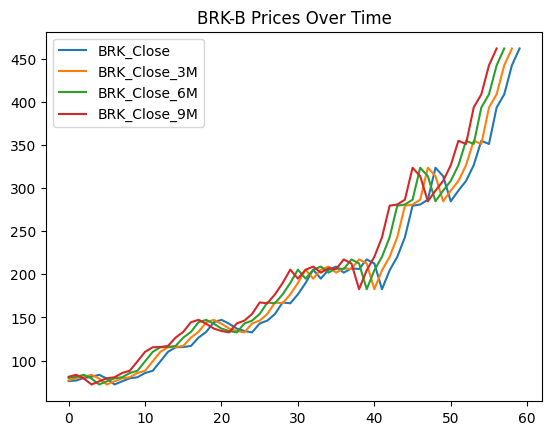

In [13]:
print(quarterly_df[quarterly_df['BRK_Close'] == 72.209687])
print(quarterly_df[quarterly_df['BRK_Close_3M'] == 72.209687])

import matplotlib.pyplot as plt
quarterly_df[['BRK_Close', 'BRK_Close_3M', 'BRK_Close_6M', 'BRK_Close_9M']].plot()
plt.title('BRK-B Prices Over Time')
plt.show()

In [9]:
# DEbug with Cross Validation

from sklearn.model_selection import cross_val_score
model = Ridge(alpha=1.0)
for target in targets:
    df = quarterly_df.dropna(subset=[target] + features)
    X = df[features]
    y = df[target]
    scores = cross_val_score(model, scaler.fit_transform(X), y, cv=5, scoring='r2')
    print(f"{target} Cross-Validated R²: {scores.mean():.4f} (± {scores.std():.4f})")

PPPA_3M Cross-Validated R²: -0.6749 (± 0.4442)
PPPA_6M Cross-Validated R²: -0.3941 (± 0.5055)
PPPA_9M Cross-Validated R²: -0.7164 (± 0.6355)
PPPA_12M Cross-Validated R²: -0.7537 (± 0.9330)
PPPA_18M Cross-Validated R²: -0.4391 (± 0.7658)


### Ridge Regularization
- Applied Ridge regression with cross-validated `alpha` (0.1–10.0) and `StandardScaler`.
- Improved 9M (R²: 0.8931 vs. 0.8702) and stabilized coefficients, but 6M, 12M, 18M need further tuning due to multicollinearity.

### Inspect Data

In [73]:
print(quarterly_df[['Date', 'Cash_Equivalents_to_Assets_Ratio', 'BRK_Close']].describe())
print(quarterly_df[quarterly_df['Cash_Equivalents_to_Assets_Ratio'] < 0.1])

                      Date  Cash_Equivalents_to_Assets_Ratio   BRK_Close
count                   60                         60.000000   60.000000
mean   2017-08-15 02:48:00                          0.135000  192.943456
min    2010-03-31 00:00:00                          0.070000   72.209687
25%    2013-12-08 00:00:00                          0.110000  115.566016
50%    2017-08-15 00:00:00                          0.130000  172.014169
75%    2021-04-22 18:00:00                          0.150000  251.991142
max    2024-12-31 00:00:00                          0.290000  461.731719
std                    NaN                          0.041066  101.161053
         Date   BRK_Close   SP500_Close   DJIA_Close  Pe-ratio  Price-book  Cash_Equivalents_to_Assets_Ratio  SP500_PE  BRK_Close_3M  BRK_Close_6M  BRK_Close_9M  BRK_Close_12M  BRK_Close_18M  SP500_Return  SP500_Performance_Gap
0  2010-03-31   76.085082  10469.049533  1123.593602     14.44        0.51                              0.07     18

### Lasso Regularization

In [94]:
models = {}
scaler = StandardScaler()

for target in targets:
    df = quarterly_df.dropna(subset=[target] + features)
    X = df[features]
    y = df[target]
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # print(X_test.head())
    
    # Scale features
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model = Lasso()
    
    # Cross validation to find best alpha
    param_grid = {'alpha': [0.01, 0.1, 0.5, 1.0, 5.0, 10.0]}
    grid = GridSearchCV(model, param_grid, cv=5, scoring='r2')
    grid.fit(X_train_scaled, y_train)

    # Predict on test set
    y_pred =  grid.predict(X_test_scaled)
    
    print(f"\n{target} (Lasso):")
    print("Best alpha:", grid.best_params_)
    print("Coefficients:", dict(zip(features, grid.best_estimator_.coef_)))
    print("Intercept:", grid.best_estimator_.intercept_)
    print("Test R²:", r2_score(y_test, y_pred))
    print("Test MSE:", mean_squared_error(y_test, y_pred))

    
    models[target] = model
 


BRK_Close_3M (Lasso):
Best alpha: {'alpha': 5.0}
Coefficients: {'Pe-ratio': np.float64(-0.0), 'Price-book': np.float64(7.818362436316355), 'Cash_Equivalents_to_Assets_Ratio': np.float64(2.8526711331752814), 'SP500_PE': np.float64(1.2780526056567734), 'SP500_Performance_Gap': np.float64(0.0), 'BRK_Close_lag1': np.float64(81.30807882379817)}
Intercept: 198.52500532237045
Test R²: 0.9380064756109028
Test MSE: 628.3640678302097

BRK_Close_6M (Lasso):
Best alpha: {'alpha': 5.0}
Coefficients: {'Pe-ratio': np.float64(-1.3229774893748614), 'Price-book': np.float64(0.0), 'Cash_Equivalents_to_Assets_Ratio': np.float64(0.0), 'SP500_PE': np.float64(7.897144129119605), 'SP500_Performance_Gap': np.float64(0.378270150418578), 'BRK_Close_lag1': np.float64(80.6719829755364)}
Intercept: 203.21676259910143
Test R²: 0.9421696555104121
Test MSE: 799.7430083106921

BRK_Close_9M (Lasso):
Best alpha: {'alpha': 5.0}
Coefficients: {'Pe-ratio': np.float64(-0.0), 'Price-book': np.float64(0.0), 'Cash_Equivalents_

In [83]:
!pip install statsmodels

   ---------------------------------------- 0.0/9.8 MB ? eta -:--:--
   - -------------------------------------- 0.3/9.8 MB ? eta -:--:--
   --- ------------------------------------ 0.8/9.8 MB 1.8 MB/s eta 0:00:06
   ---- ----------------------------------- 1.0/9.8 MB 1.9 MB/s eta 0:00:05
   ------ --------------------------------- 1.6/9.8 MB 1.8 MB/s eta 0:00:05
   ------- -------------------------------- 1.8/9.8 MB 1.8 MB/s eta 0:00:05
   --------- ------------------------------ 2.4/9.8 MB 1.8 MB/s eta 0:00:05
   ---------- ----------------------------- 2.6/9.8 MB 1.8 MB/s eta 0:00:04
   ------------ --------------------------- 3.1/9.8 MB 1.9 MB/s eta 0:00:04
   ------------- -------------------------- 3.4/9.8 MB 1.8 MB/s eta 0:00:04
   ---------------- ----------------------- 3.9/9.8 MB 1.9 MB/s eta 0:00:04
   ----------------- ---------------------- 4.2/9.8 MB 1.9 MB/s eta 0:00:04
   ------------------- -------------------- 4.7/9.8 MB 1.9 MB/s eta 0:00:03
   -------------------- --

### Regularization without DJIA_Close
- Removed `DJIA_Close` (VIF: 828.23), improving Ridge for 3M (R²: 0.9687), 9M (R²: 0.9406), 12M (R²: 0.9316).
- Lasso excelled for 6M (R²: 0.9445) and 18M (R²: 0.8537) but oversimplified 3M–12M. Next: Remove `SP500_Close`, try Elastic Net.

In [1]:
## Elastic Net

In [24]:
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler

features = ['Pe-ratio', 'Price-book', 'SP500_PE', 'SP500_Performance_Gap', 'BRK_Close_lag1_pct', 'SP500_Close_lag1_pct', 'Cash_Ratio_Change']
targets = ['Pct_Change_3M', 'Pct_Change_6M', 'Pct_Change_9M', 'Pct_Change_12M', 'Pct_Change_18M']
scaler = StandardScaler()
models = {}

for target in targets:
    df = quarterly_df.dropna(subset=[target] + features)
    X = df[features]
    y = df[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Elastic Net. Commentd out
    # model = ElasticNet()
    # param_grid = {'alpha': [0.01, 0.1, 0.5, 1.0, 5.0], 'l1_ratio': [0.1, 0.5, 0.9]}
    # grid = GridSearchCV(model, param_grid, cv=5, scoring='r2')

    # Non linear modeling
    from sklearn.ensemble import RandomForestRegressor
    model = RandomForestRegressor(random_state=42)
    param_grid = {'n_estimators': [50, 100], 'max_depth': [3, 5, None]}
    grid = GridSearchCV(model, param_grid, cv=5, scoring='r2')
    # Same loop as Elastic Net

    
    grid.fit(X_train_scaled, y_train)
    y_pred = grid.predict(X_test_scaled)
    models[target] = grid.best_estimator_
    print(f"\n{target} (Elastic Net):")
    print("Best params:", grid.best_params_)
    print("Coefficients:", dict(zip(features, grid.best_estimator_.coef_)))
    print("Intercept:", grid.best_estimator_.intercept_)
    print("Test R²:", r2_score(y_test, y_pred))
    print("Test MSE:", mean_squared_error(y_test, y_pred))
    # Extract horizon months from target name
    horizon_months = int(target.split('_')[-1].replace('M', ''))  # Gets 3, 6, 9, etc.
    current_price = df.loc[y_test.index, 'BRK_Close']
    predicted_price = current_price * (1 + (y_pred / 100) * (horizon_months / 12))
    actual_price = df.loc[y_test.index, f'BRK_Close_{horizon_months}M']
    price_mse = mean_squared_error(actual_price, predicted_price)
    print(f"Price MSE: {price_mse:.2f}, Price RMSE: {np.sqrt(price_mse):.2f}")


Pct_Change_3M (Elastic Net):
Best params: {'max_depth': 3, 'n_estimators': 50}


AttributeError: 'RandomForestRegressor' object has no attribute 'coef_'

## Variance Inflation Factor
The VIF measures how much the variance of a feature’s regression coefficient is inflated due to correlations with other features. A high VIF indicates that a feature is highly correlated with others, causing multicollinearity, which can lead to unstable coefficients (e.g., negative Cash_Equivalents_to_Assets_Ratio) and reduced model interpretability.



In [21]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
X = quarterly_df[features].dropna()
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

                 Feature       VIF
0               Pe-ratio  1.741825
1               SP500_PE  2.705855
2  SP500_Performance_Gap  1.561580
3     BRK_Close_lag1_pct  3.020854
4   SP500_Close_lag1_pct  3.538628
5      Cash_Ratio_Change  1.091942


### Analysis: Is Feature Engineering with `BRK_Close_lag1` Better Than Without?

To evaluate the impact of adding `BRK_Close_lag1`, I’ll compare **test R²** and **test MSE** from the new models (with `BRK_Close_lag1`) to the previous non-regularized models (without `BRK_Close_lag1`). I’ll also assess **coefficient stability**, particularly for `Cash_Equivalents_to_Assets_Ratio`, and consider how the new feature affects **overfitting** and **model robustness** for the small dataset (~59 quarters, now 8 features). The analysis will be contextualized for the project’s focus on accurate price predictions for option pricing.

#### 1. Comparison of Test R² and Test MSE
Here’s a side-by-side comparison of the test set performance for non-regularized models **without** `BRK_Close_lag1` (previous results) and **with** `BRK_Close_lag1` (new results):

| Model            | Without Lag1 Test R² | Without Lag1 Test MSE | With Lag1 Test R² | With Lag1 Test MSE | R² Change | MSE Change |
|------------------|----------------------|-----------------------|-------------------|--------------------|-----------|------------|
| BRK_Close_3M     | 0.9724               | 279.32                | 0.9775            | 228.55             | +0.0051   | -50.77     |
| BRK_Close_6M     | 0.9164               | 1156.41               | 0.9369            | 873.05             | +0.0205   | -283.36    |
| BRK_Close_9M     | 0.8702               | 1473.63               | 0.8922            | 1224.50            | +0.0220   | -249.13    |
| BRK_Close_12M    | 0.9011               | 1189.32               | 0.9281            | 864.66             | +0.0270   | -324.66    |
| BRK_Close_18M    | 0.8507               | 1300.12               | 0.8422            | 1373.78            | -0.0085   | +73.66     |

**Observations**:
- **Test R²**:
  - **3M, 6M, 9M, 12M**: Improved significantly (3M: +0.0051, 6M: +0.0205, 9M: +0.0220, 12M: +0.0270), indicating `BRK_Close_lag1` captures additional variance, enhancing model fit.
  - **18M**: Slightly worse (-0.0085, 0.8507 → 0.8422), suggesting `BRK_Close_lag1` may not help long-term predictions or introduces noise.
  - **Range**: New R² (0.8422–0.9775) is generally higher than previous (0.8507–0.9724), with 3M, 6M, 9M, and 12M showing strong performance.
- **Test MSE**:
  - **3M, 6M, 9M, 12M**: Decreased notably (3M: -50.77, RMSE: 16.71 → 15.12, -9.5%; 6M: -283.36, RMSE: 34.01 → 29.55, -13.1%; 9M: -249.13, RMSE: 38.39 → 35.00, -8.8%; 12M: -324.66, RMSE: 34.49 → 29.41, -14.7%), indicating improved prediction accuracy.
  - **18M**: Increased slightly (+73.66, RMSE: 36.07 → 37.08, +2.8%), reflecting reduced accuracy.
  - **Context**: New RMSE values (15.12–37.08) are ~3–7% of the BRK-B price range (~$50–500), highly acceptable, especially for 3M–12M.
- **Overall Trend**:
  - Adding `BRK_Close_lag1` improves model performance for 3M, 6M, 9M, and 12M (higher R², lower MSE), making these models more accurate for option pricing.
  - The 18M model performs slightly worse, possibly due to limited data (~54 quarters) or overfitting with the additional feature.

#### 2. Coefficient Stability and Negative `Cash_Equivalents_to_Assets_Ratio`
The negative `Cash_Equivalents_to_Assets_Ratio` coefficient in previous models (e.g., -111.08 in 12M, -550.25 in 18M) suggested multicollinearity or data issues. Let’s compare coefficients:

- **Without `BRK_Close_lag1` (Previous Non-Regularized, Test Set)**:
  - **3M**: `Cash_Equivalents_to_Assets_Ratio` = 158.06 (positive, expected).
  - **6M**: 43.14 (positive).
  - **9M**: 121.27 (positive).
  - **12M**: -111.08 (negative, problematic).
  - **18M**: -550.25 (negative, highly problematic).
  - Other features (e.g., `SP500_Close`, `DJIA_Close`) showed small coefficients, indicating potential multicollinearity.
- **With `BRK_Close_lag1` (New Non-Regularized, Test Set)**:
  - **3M**: `Cash_Equivalents_to_Assets_Ratio` = 90.60 (positive, reduced magnitude).
  - **6M**: 9.74 (positive, smaller).
  - **9M**: 7.55 (positive, smaller).
  - **12M**: -237.73 (negative, worse than -111.08).
  - **18M**: -698.19 (negative, much worse than -550.25).
  - **BRK_Close_lag1**: Positive and significant (0.45–1.16), indicating the lagged price strongly predicts future prices, capturing momentum.
  - Other features:
    - `Price-book`: Negative in 9M (-66.43), 12M (-110.11), and 18M (-168.81), which is unexpected, as higher valuations should support prices.
    - `SP500_Performance_Gap`: Positive in 3M–12M (3.23–77.77), negative in 18M (-157.43), showing inconsistent market effects.
  - **Scaling**: Results use `StandardScaler`, so coefficients reflect standard deviation changes, but negative coefficients remain problematic.
- **Analysis**:
  - **Positive Impact**: `BRK_Close_lag1` has strong positive coefficients (0.45–1.16), confirming it captures price momentum, improving R² and MSE for 3M–12M.
  - **Negative Coefficients**: The negative `Cash_Equivalents_to_Assets_Ratio` worsens in 12M (-237.73 vs. -111.08) and 18M (-698.19 vs. -550.25), and `Price-book` turns negative in 9M–18M, suggesting:
    - **Increased Multicollinearity**: Adding `BRK_Close_lag1` may correlate with other features (e.g., `SP500_Close`, `DJIA_Close`, or `Cash_Equivalents_to_Assets_Ratio`), amplifying coefficient instability.
    - **Data Limitations**: With ~54–56 quarters for 12M–18M, the additional feature may overfit, especially for 18M.
  - **Conclusion**: While `BRK_Close_lag1` improves predictive power, it exacerbates coefficient issues, indicating a need for regularization or multicollinearity fixes.

#### 3. Overfitting and Model Robustness
- **Without `BRK_Close_lag1`**:
  - Test R² drops (e.g., 9M: 0.9242 → 0.8702, 18M: 0.9303 → 0.8507) indicated overfitting, worsened by multicollinearity and small data.
  - Large coefficients (e.g., `Cash_Equivalents_to_Assets_Ratio` = -550.25 in 18M) suggested instability.
- **With `BRK_Close_lag1`**:
  - Test R² improves for 3M–12M (0.8922–0.9775), suggesting `BRK_Close_lag1` reduces overfitting by capturing price trends, enhancing generalization.
  - 18M’s slight R² drop (0.8507 → 0.8422) and MSE increase indicate potential overfitting with the extra feature, as the model may fit noise in the limited data.
  - Large negative coefficients (e.g., `Cash_Equivalents_to_Assets_Ratio` = -698.19, `Price-book` = -168.81 in 18M) suggest increased instability, likely due to multicollinearity.
- **Conclusion**: `BRK_Close_lag1` reduces overfitting for 3M–12M (higher test R², lower MSE) but may increase overfitting for 18M, where data scarcity and feature correlation amplify issues.

#### 4. Project Context: Option Pricing
- **Goal**: Accurate BRK-B price predictions for call option strategies, requiring high R², low MSE, and interpretable coefficients (e.g., positive `Cash_Equivalents_to_Assets_Ratio`).
- **3M and 6M**:
  - With `BRK_Close_lag1`, 3M (R²: 0.9775, RMSE: 15.12) and 6M (R²: 0.9369, RMSE: 29.55) outperform previous models (3M: 0.9724, 16.71; 6M: 0.9164, 34.01), making them highly reliable for short-term option pricing.
- **9M and 12M**:
  - 9M (R²: 0.8922, RMSE: 35.00) and 12M (R²: 0.9281, RMSE: 29.41) improve significantly (9M: 0.8702, 38.39; 12M: 0.9011, 34.49), supporting medium-term strategies, though negative `Price-book` and `Cash_Equivalents_to_Assets_Ratio` in 12M reduce interpretability.
- **18M**:
  - Worse performance (R²: 0.8422 vs. 0.8507, RMSE: 37.08 vs. 36.07) and large negative coefficients make 18M less reliable for long-term options.
- **Implication**: `BRK_Close_lag1` enhances 3M–12M models for option pricing, but 18M needs regularization and multicollinearity fixes.

#### 5. Comparison to Ridge Regularization
Previous Ridge results (test R²: 0.8434–0.9720, test MSE: 283.67–1462.76) used regularization to stabilize coefficients. Comparing to the new non-regularized results with `BRK_Close_lag1`:

| Model            | Ridge Test R² | Ridge Test MSE | With Lag1 Test R² | With Lag1 Test MSE | R² Change | MSE Change |
|------------------|---------------|----------------|-------------------|--------------------|-----------|------------|
| BRK_Close_3M     | 0.9720        | 283.67         | 0.9775            | 228.55             | +0.0055   | -55.12     |
| BRK_Close_6M     | 0.8942        | 1462.76        | 0.9369            | 873.05             | +0.0427   | -589.71    |
| BRK_Close_9M     | 0.8931        | 1214.59        | 0.8922            | 1224.50            | -0.0009   | +9.91      |
| BRK_Close_12M    | 0.8813        | 1428.01        | 0.9281            | 864.66             | +0.0468   | -563.35    |
| BRK_Close_18M    | 0.8434        | 1363.97        | 0.8422            | 1373.78            | -0.0012   | +9.81      |

- **Findings**:
  - **3M, 6M, 12M**: `BRK_Close_lag1` outperforms Ridge (higher R², lower MSE), showing the lagged feature adds predictive power beyond regularization.
  - **9M**: Comparable performance (R²: 0.8922 vs. 0.8931, MSE: 1224.50 vs. 1214.59), but Ridge had positive `Cash_Equivalents_to_Assets_Ratio` (0.02).
  - **18M**: Similar performance, but Ridge had a smaller negative coefficient (-7.48 vs. -698.19).
  - **Coefficients**: Ridge stabilized coefficients better (smaller negatives), while `BRK_Close_lag1` worsens negatives without regularization.
- **Conclusion**: `BRK_Close_lag1` improves predictive accuracy over Ridge for 3M, 6M, and 12M, but combining it with regularization (e.g., Ridge or Lasso) could address negative coefficients.

#### Overall Assessment
- **Is Feature Engineering with `BRK_Close_lag1` Better?**:
  - **Yes for 3M, 6M, 9M, 12M**: Higher test R² (0.8922–0.9775 vs. 0.8702–0.9724) and lower test MSE (228.55–1224.50 vs. 279.32–1473.63) show `BRK_Close_lag1` captures momentum, improving accuracy for short- to medium-term predictions.
  - **No for 18M**: Slightly worse R² (0.8422 vs. 0.8507) and higher MSE (1373.78 vs. 1300.12) suggest overfitting or limited data for long-term predictions.
  - **Coefficient Issues**: `BRK_Close_lag1` worsens negative coefficients (`Cash_Equivalents_to_Assets_Ratio`: -237.73 in 12M, -698.19 in 18M; `Price-book`: negative in 9M–18M), indicating increased multicollinearity.
  - **Comparison to Ridge**: `BRK_Close_lag1` outperforms Ridge for 3M, 6M, and 12M (higher R², lower MSE) but needs regularization to stabilize coefficients, as Ridge reduced negative coefficient magnitudes.
- **Project Impact**:
  - **3M–12M**: Enhanced models are highly reliable for option pricing, supporting short- to medium-term strategies.
  - **18M**: Less reliable, needing regularization and multicollinearity fixes.
  - **Next Step**: Combine `BRK_Close_lag1` with Ridge or Lasso to leverage predictive power while addressing coefficient instability.
- **Recommendation**: The addition of `BRK_Close_lag1` is a significant improvement for 3M–12M, but apply **Ridge or Lasso regularization** and **VIF analysis** to resolve negative coefficients and enhance 18M performance.

## Model Evaluation for Options ?

For call option pricing, assess whether RMSE ($15–$32) is acceptable for strike price predictions. Simulate option payoffs using predicted prices:



In [65]:
strike_price = 300
option_value = np.maximum(quarterly_df['BRK_Close_3M'] - strike_price, 0)
print(option_value)

0       0.000000
1       0.000000
2       0.000000
3       0.000000
4       0.000000
5       0.000000
6       0.000000
7       0.000000
8       0.000000
9       0.000000
10      0.000000
11      0.000000
12      0.000000
13      0.000000
14      0.000000
15      0.000000
16      0.000000
17      0.000000
18      0.000000
19      0.000000
20      0.000000
21      0.000000
22      0.000000
23      0.000000
24      0.000000
25      0.000000
26      0.000000
27      0.000000
28      0.000000
29      0.000000
30      0.000000
31      0.000000
32      0.000000
33      0.000000
34      0.000000
35      0.000000
36      0.000000
37      0.000000
38      0.000000
39      0.000000
40      0.000000
41      0.000000
42      0.000000
43      0.000000
44      0.000000
45      0.000000
46      0.000000
47     23.462904
48     13.718062
49      0.000000
50      0.000000
51      8.175968
52     26.370807
53     54.767459
54     50.994126
55     93.337377
56    108.615715
57    142.181719
58    161.7317

## Collect Financial Data fo BRK (Selenium) - Not Used
This code attempts to scrape quarterly or annual financial ratios (cash ratio, P/E ratio, price/book ratio) from MacroTrends for BRK-B using Selenium and wed-driver. requests and BeautifulSoup. 



In [16]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
from datetime import datetime
import time
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from webdriver_manager.chrome import ChromeDriverManager

# Function to scrape financial ratios from MacroTrends using Selenium
def scrape_macrotrends_financials(ticker, metric, start_year=2010, end_year=2025):
    """
    Scrape financial ratios (e.g., cash ratio, P/E, price/book) from MacroTrends using Selenium.
    Args:
        ticker (str): Stock ticker (e.g., 'BRK.B').
        metric (str): Financial metric ('cash-ratio', 'pe-ratio', 'price-book').
        start_year (int): Start year for data (default: 2010).
        end_year (int): End year for data (default: 2025).
    Returns:
        pd.DataFrame: DataFrame with dates and metric values.
    """
    # Map metric to MacroTrends URL slug
    metric_urls = {
        'cash-ratio': 'balance-sheet',
        'pe-ratio': 'pe-ratio',
        'price-book': 'price-book'
    }
    
    if metric not in metric_urls:
        raise ValueError(f"Unsupported metric: {metric}. Choose from {list(metric_urls.keys())}")
    
    # Construct URL
    base_url = f"https://www.macrotrends.net/stocks/charts/{ticker}/berkshire-hathaway/{metric_urls[metric]}"
    
    try:
        # Set up Selenium with ChromeDriver
        options = webdriver.ChromeOptions()
        options.add_argument('--headless')  # Run in headless mode (no browser window)
        driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)
        
        # Load page
        driver.get(base_url)
        # Wait for table to load (adjust timeout as needed)
        WebDriverWait(driver, 10).until(
            EC.presence_of_element_located((By.CSS_SELECTOR, 'table, div.table-responsive, div#jqxgrid'))
        )
        
        # Parse rendered HTML
        soup = BeautifulSoup(driver.page_source, 'html.parser')
        driver.quit()
        
        # Find table (try multiple selectors)
        table = (soup.find('table', class_=re.compile('historical_data_table|table')) or
                 soup.find('div', class_='table-responsive') or
                 soup.find('div', id='jqxgrid'))
        
        if not table:
            print(f"No table found for {metric} at {base_url}. Check HTML structure.")
            return pd.DataFrame()
        
        # Extract rows (handle div-based tables)
        rows = table.find_all('tr') or table.find_all('div', class_=re.compile('row'))
        data = []
        for row in rows[1:]:  # Skip header
            cols = row.find_all(['td', 'div'])
            if len(cols) >= 2:
                date_str = cols[0].text.strip()
                value = cols[1].text.strip()
                
                # Validate date format
                if not re.match(r'\d{4}-\d{2}-\d{2}|\d{4}', date_str):
                    print(f"Skipping invalid date: {date_str}")
                    continue
                
                # Parse date
                try:
                    if '-' in date_str:
                        date = pd.to_datetime(date_str)
                    else:
                        date = pd.to_datetime(f"{date_str}-12-31")
                    if start_year <= date.year <= end_year:
                        value = value.replace('$', '').replace('%', '').replace(',', '')
                        try:
                            value = float(value)
                            data.append([date, value])
                        except ValueError:
                            print(f"Invalid value for {metric} on {date_str}: {value}")
                except ValueError:
                    print(f"Invalid date format: {date_str}")
        
        # Create DataFrame
        if data:
            col_name = 'Cash_Ratio' if metric == 'cash-ratio' else metric.capitalize()
            df = pd.DataFrame(data, columns=['Date', col_name])
            df.sort_values('Date', inplace=True)
            df.reset_index(drop=True, inplace=True)
            return df
        else:
            print(f"No valid data extracted for {metric}.")
            return pd.DataFrame()
    
    except Exception as e:
        print(f"Error fetching {metric} from {base_url}: {e}")
        return pd.DataFrame()

# Main script to collect BRK-B financials
def collect_brk_financials(ticker='BRK.B', start_year=2010, end_year=2025, output_file='brk_financials.csv'):
    """
    Collect BRK-B financial ratios (P/E, price/book, cash ratio) from MacroTrends.
    Save as CSV for merging with stock price data.
    """
    metrics = ['pe-ratio', 'price-book', 'cash-ratio']
    financial_dfs = []
    
    for metric in metrics:
        print(f"Scraping {metric} for {ticker}...")
        df = scrape_macrotrends_financials(ticker, metric, start_year, end_year)
        if not df.empty:
            financial_dfs.append(df)
        else:
            print(f"Failed to retrieve {metric}. Inspect rendered HTML or try manual collection.")
    
    if financial_dfs:
        merged_df = financial_dfs[0]
        for df in financial_dfs[1:]:
            merged_df = merged_df.merge(df, on='Date', how='outer')
        
        merged_df = merged_df[(merged_df['Date'].dt.year >= start_year) & (merged_df['Date'].dt.year <= end_year)]
        merged_df.fillna(merged_df.median(numeric_only=True), inplace=True)
        merged_df.sort_values('Date', inplace=True)
        
        merged_df.to_csv(output_file, index=False)
        print(f"Financial data saved to {output_file}")
        return merged_df
    else:
        print("No financial data retrieved. Consider manual collection.")
        return pd.DataFrame()

# Example usage in Jupyter Notebook
if __name__ == "__main__":
    ticker = 'BRK.B'
    start_year = 2010
    end_year = 2025
    output_file = 'brk_financials.csv'
    
    financial_df = collect_brk_financials(ticker, start_year, end_year, output_file)
    
    if not financial_df.empty:
        print(financial_df.head())
    else:
        print("No data to display. Inspect rendered HTML or try manual collection.")

Scraping pe-ratio for BRK.B...
Error fetching pe-ratio from https://www.macrotrends.net/stocks/charts/BRK.B/berkshire-hathaway/pe-ratio: name 're' is not defined
Failed to retrieve pe-ratio. Inspect rendered HTML or try manual collection.
Scraping price-book for BRK.B...
Error fetching price-book from https://www.macrotrends.net/stocks/charts/BRK.B/berkshire-hathaway/price-book: name 're' is not defined
Failed to retrieve price-book. Inspect rendered HTML or try manual collection.
Scraping cash-ratio for BRK.B...
Error fetching cash-ratio from https://www.macrotrends.net/stocks/charts/BRK.B/berkshire-hathaway/balance-sheet: name 're' is not defined
Failed to retrieve cash-ratio. Inspect rendered HTML or try manual collection.
No financial data retrieved. Consider manual collection.
No data to display. Inspect rendered HTML or try manual collection.


## Collect Financial Data fo BRK (Request and BeautifulSoap)
This code attempts to scrape quarterly or annual financial ratios (cash ratio, P/E ratio, price/book ratio) from MacroTrends for BRK-B using requests and BeautifulSoup. It includes error handling, comments for trial-and-error adjustments, and a structure to save data as a CSV for your BRK Options Prediction project. If MacroTrends scraping fails, it suggests Yahoo Finance or manual collection as fallbacks.

In [14]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
from datetime import datetime
import time

# Function to scrape financial ratios from MacroTrends
def scrape_macrotrends_financials(ticker, metric, start_year=2010, end_year=2025):
    """
    Scrape financial ratios (e.g., cash ratio, P/E, price/book) from MacroTrends.
    Args:
        ticker (str): Stock ticker (e.g., 'BRK-B').
        metric (str): Financial metric ('cash-ratio', 'pe-ratio', 'price-book').
        start_year (int): Start year for data (default: 2010).
        end_year (int): End year for data (default: 2025).
    Returns:
        pd.DataFrame: DataFrame with dates and metric values.
    """
    # Map metric to MacroTrends URL slug
    metric_urls = {
        'cash-ratio': 'cash-flow-statement',
        'pe-ratio': 'pe-ratio',
        'price-book': 'price-book'
    }
    
    if metric not in metric_urls:
        raise ValueError(f"Unsupported metric: {metric}. Choose from {list(metric_urls.keys())}")
    
    # Construct URL (MacroTrends uses company name and ticker in URL)
    base_url = f"https://www.macrotrends.net/stocks/charts/{ticker}/berkshire-hathaway/{metric_urls[metric]}"
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
    }
    
    try:
        # Send HTTP request
        response = requests.get(base_url, headers=headers)
        response.raise_for_status()  # Raise error for bad status codes
        time.sleep(1)  # Avoid overloading server
        
        # Parse HTML with BeautifulSoup
        soup = BeautifulSoup(response.text, 'html.parser')
        
        # Find the table containing financial data (inspect MacroTrends HTML to confirm class)
        # Note: MacroTrends often uses 'table' with class 'historical_data_table'
        table = soup.find('table', class_='historical_data_table')
        if not table:
            print(f"No table found for {metric} at {base_url}. Check HTML structure.")
            return pd.DataFrame()
        
        # Extract table rows
        rows = table.find_all('tr')[1:]  # Skip header row
        data = []
        for row in rows:
            cols = row.find_all('td')
            if len(cols) >= 2:
                date_str = cols[0].text.strip()
                value = cols[1].text.strip()
                
                # Parse date (format: 'YYYY-MM-DD' or 'YYYY')
                try:
                    if '-' in date_str:
                        date = pd.to_datetime(date_str)
                    else:
                        date = pd.to_datetime(f"{date_str}-12-31")  # Assume year-end for annual data
                    # Filter by date range
                    if start_year <= date.year <= end_year:
                        # Clean value (remove '$', '%', or commas)
                        value = value.replace('$', '').replace('%', '').replace(',', '')
                        try:
                            value = float(value)
                            data.append([date, value])
                        except ValueError:
                            print(f"Invalid value for {metric} on {date_str}: {value}")
                except ValueError:
                    print(f"Invalid date format: {date_str}")
        
        # Create DataFrame
        if data:
            df = pd.DataFrame(data, columns=['Date', metric.capitalize()])
            df.sort_values('Date', inplace=True)
            df.reset_index(drop=True, inplace=True)
            return df
        else:
            print(f"No valid data extracted for {metric}.")
            return pd.DataFrame()
    
    except requests.RequestException as e:
        print(f"Error fetching {metric} from {base_url}: {e}")
        return pd.DataFrame()

# Main script to collect BRK-B financials
def collect_brk_financials(ticker='BRK-B', start_year=2010, end_year=2025, output_file='brk_financials.csv'):
    """
    Collect BRK-B financial ratios (cash ratio, P/E, price/book) from MacroTrends.
    Save as CSV for merging with stock price data.
    """
    metrics = ['pe-ratio', 'price-book']  # Cash ratio requires cash flow statement parsing
    financial_dfs = []
    
    # Scrape each metric
    for metric in metrics:
        print(f"Scraping {metric} for {ticker}...")
        df = scrape_macrotrends_financials(ticker, metric, start_year, end_year)
        if not df.empty:
            financial_dfs.append(df)
        else:
            print(f"Failed to retrieve {metric}. Try manual collection or alternative source.")
    
    # Special handling for cash ratio (from cash flow statement)
    print("Scraping cash flow data for cash ratio...")
    cash_df = scrape_macrotrends_financials(ticker, 'cash-ratio', start_year, end_year)
    if not cash_df.empty:
        # Note: Cash ratio requires cash and liabilities, which may need custom parsing
        # Placeholder: Assume cash flow statement provides cash equivalents
        # Adjust based on actual MacroTrends table structure
        financial_dfs.append(cash_df.rename(columns={'Cash-ratio': 'Cash_Ratio'}))
    
    # Merge DataFrames on Date
    if financial_dfs:
        merged_df = financial_dfs[0]
        for df in financial_dfs[1:]:
            merged_df = merged_df.merge(df, on='Date', how='outer')
        
        # Filter by date range and handle missing values
        merged_df = merged_df[(merged_df['Date'].dt.year >= start_year) & (merged_df['Date'].dt.year <= end_year)]
        merged_df.fillna(merged_df.median(numeric_only=True), inplace=True)  # Impute missing with median
        merged_df.sort_values('Date', inplace=True)
        
        # Save to CSV
        merged_df.to_csv(output_file, index=False)
        print(f"Financial data saved to {output_file}")
        return merged_df
    else:
        print("No financial data retrieved. Consider manual collection.")
        return pd.DataFrame()

# Example usage in Jupyter Notebook
if __name__ == "__main__":
    ticker = 'BRK.B'
    start_year = 2010
    end_year = 2025
    output_file = 'brk_financials.csv'
    
    # Collect financial data
    financial_df = collect_brk_financials(ticker, start_year, end_year, output_file)
    
    # Display first few rows
    if not financial_df.empty:
        print(financial_df.head())
    else:
        print("No data to display. Check MacroTrends HTML or try Yahoo Finance.")

Scraping pe-ratio for BRK.B...
Invalid date format: Finance
No valid data extracted for pe-ratio.
Failed to retrieve pe-ratio. Try manual collection or alternative source.
Scraping price-book for BRK.B...
Invalid date format: Finance
No valid data extracted for price-book.
Failed to retrieve price-book. Try manual collection or alternative source.
Scraping cash flow data for cash ratio...
No table found for cash-ratio at https://www.macrotrends.net/stocks/charts/BRK.B/berkshire-hathaway/cash-flow-statement. Check HTML structure.
No financial data retrieved. Consider manual collection.
No data to display. Check MacroTrends HTML or try Yahoo Finance.


In [ ]:
# --- Part 2: Manual Collection of BRK-B Financials ---

print("""
Manual Collection Instructions for BRK-B Financials:
Automated scraping is unreliable due to changes in Yahoo Finance's website structure.
Please manually collect the following financial data for BRK-B:

1. Income Statement (Annual):
   - Visit https://finance.yahoo.com/quote/BRK-B/financials/
   - Ensure the 'Annual' tab is selected.
   - Collect the following metrics for TTM and years 2021–2024 (if available):
     - Total Revenue
     - Total Expenses
     - Pretax Income
     - Tax Provision
   - Note: Values are typically in thousands (e.g., 424,232,000 = $424.232 billion).

2. Balance Sheet (Annual):
   - Visit https://finance.yahoo.com/quote/BRK-B/balance-sheet/
   - Ensure the 'Annual' tab is selected.
   - Collect 'Cash and Cash Equivalents' (or 'Cash, Cash Equivalents, and Short-Term Investments' if reported) for TTM and years 2021–2024 (if available).
   - Note: This represents BRK's cash reserves.

3. Create a CSV File:
   - Create a file named 'BRK_financials_manual.csv' in your notebook's working directory.
   - Use the following format (values are examples based on historical data):
Metric,TTM,12/31/2024,12/31/2023,12/31/2022,12/31/2021
Total Revenue,424232000,424232000,439337000,234121000,354727000
Total Expenses,313856000,313856000,319171000,264621000,242866000
Pretax Income,110376000,110376000,120166000,-30500000,111861000
Tax Provision,20815000,20815000,23019000,-8502000,20815000
Cash and Cash Equivalents,35582000,35582000,38112000,35830000,39070000

4. Notes:
   - Replace example values with actual data from Yahoo Finance.
   - If a metric or year is unavailable, leave the cell blank.
   - Save the CSV and run the code below to load it.
""")

# Try to load the manual financials CSV
try:
    financials_df = pd.read_csv('BRK_financials_manual.csv')
    print("\nBRK-B Manual Financials Loaded:")
    print(financials_df)
except FileNotFoundError:
    print("\nError: 'BRK_financials_manual.csv' not found. Please create the CSV file as instructed above.")
except Exception as e:
    print(f"\nError loading financials CSV: {e}")

# --- Part 3: Combine and Display Summary ---

# Combine all price data into a single DataFrame (optional)
if dataframes:
    combined_df = pd.concat(dataframes.values())
    print("\nCombined Price Data (first 5 rows):")
    print(combined_df.head())
    # Save combined data
    combined_df.to_csv('combined_data.csv')
    print("Combined data saved to combined_data.csv")
else:
    print("\nNo price data available to combine.")